![logo](./figures/LogoLine_horizon_C3S.png)

# Global Warming Levels (GWLs)

This notebook is a collection of recipes for calculating Global Warming Levels (GWLs) in the CMIP5 and CMIP6 ["Copernicus Interactive Climate Atlas: gridded monthly dataset"](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview) produced by the Copernicus Atlas. It illustrates the entire process, including data access, selection, preparation, computation of GWL periods, and visualization.

Note that this notebook is intended for reproducibility purposes and is not yet well organized or fully documented.

**<span style="color:red">Please be advised that downloading the required data for this script may take several minutes.</span>**

### Load Python packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import glob
from pathlib import Path
import cdsapi

from c3s_atlas.utils import (
    extract_zip_and_delete,
)

### Test

In [12]:
## Unitary test for the rolling mean function implemented in xarray
da = xr.DataArray(
    np.linspace(0, 11, num=12),
    coords=[
        pd.date_range("1999-12-15",periods=12, freq=pd.DateOffset(months=1),)
    ],
    dims="time",
)
da_rolling = da.rolling(time=3, center=False, min_periods=1).mean()
msg = "The definition of the rolling window boundaries implemented in xarray have changed"
assert da_rolling[-1].data == 10, msg

### Define functions

In [13]:
def GSAT(ds: xr.Dataset) -> xr.Dataset:
    """
    Calculate GSAT (Global‐mean Surface Air Temperature)
    
    Parameters
    ----------
    ds : xr.Dataset
    
    Returns
    -------
    ds : xr.Dataset
    """
    # Temporal aggregation
    ds = ds.resample(time="A").mean(skipna = True)
    # Spatial aggregation
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    tas_weighted = ds.weighted(weights)
    tas_weighted_mean = tas_weighted.mean(("lon", "lat"), skipna = True)
    return tas_weighted_mean

### Download climate data with the CDS API
- Catalogue: [Copernicus Interactive Climate Atlas: gridded monthly dataset](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview)

- [How to use the CDS API](https://cds.climate.copernicus.eu/how-to-api)

In [23]:
scenarios = {'CMIP6': ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585'],
             'CMIP5': ['historical', 'rcp26', 'rcp45', 'rcp85']}

##### Download data

In [ ]:
for project in scenarios.keys():
    for scenario in scenarios[project]:
        dest = Path(f'./data/{project}/{scenario}')
        os.makedirs(dest, exist_ok=True)
        filename = f't_{project}_{scenario}.zip'
        dataset = "multi-origin-c3s-atlas"
        request = {
            'origin': 'cmip6',
            'experiment': 'ssp5_8_5',
            'domain': 'global',
            'variable': 'monthly_mean_of_daily_mean_temperature',
        }
        
        client = cdsapi.Client()
        client.retrieve(dataset, request).download(dest / filename)
        extract_zip_and_delete(dest / filename) 

### Define inputs

In [25]:
root_dataset = './data/'

In [26]:
variable = 't'
GWLs = ['1.5', '2', '3', '4']
scenarios = {'CMIP6': ['ssp126', 'ssp245', 'ssp370', 'ssp585'],
             'CMIP5': ['rcp26', 'rcp45', 'rcp85']}
PI_period = slice('1850', '1900')
window_width = 20
projects = ['CMIP5', 'CMIP6']

## CMIP6 and CMIP5

In [ ]:
for project in projects:
    
    # list of files
    root = root_dataset + project + '/'
    # find all .nc files in a root
    files = glob.glob(root + '/*/*.nc')
    files = [file for file in files if '/' + variable + '_' in file]

    # create a empty dataframe to store the results
    #(see https://github.com/IPCC-WG1/Atlas/blob/main/warming-levels/CMIP6_Atlas_WarmingLevels.csv)
    file_hist = [f for f in files if 'historical' in f][0]
    ds_hist = xr.open_dataset(file_hist)
    simulations = ds_hist.member_id.values
    columns = pd.MultiIndex.from_tuples([(GWL, sce) for sce in scenarios[project] for GWL in GWLs])
    df_GWLs = pd.DataFrame('9999', index = simulations, columns = columns)
    # Define dataframe to store the rolling mean series (used for plotting)
    columns = pd.MultiIndex.from_tuples([(sce, sim) for sce in scenarios[project] for sim in simulations])
    df_GWLs_serie = pd.DataFrame(index = pd.date_range(start = '1850', end = '2101', freq = 'A'), columns = columns)


    for sim in df_GWLs.index:        
        model = '_'.join(sim.split('_')[0:2])
        member = sim.split('_')[2]
        
        # Select historical simulations and calculate GSAT
        ds_hist = xr.open_mfdataset(file_hist, chunks = {'member':1})
        ds_hist = ds_hist.isel(member = np.where(ds_hist.member_id == sim)[0])
        ds_hist = GSAT(ds_hist)
        ds_hist_PI = ds_hist.sel(time = PI_period)
        ds_hist_PI_mean = ds_hist_PI['t'].mean()
        ds_hist.close()

        # Select future simulations
        for sce in scenarios[project]:
            ds_sce = xr.open_mfdataset([f for f in files if sce in f][0], chunks = {'member':1})
            if not np.where(ds_sce.member_id == sim)[0]:
                continue
            ds_sce = ds_sce.isel(member = np.where(ds_sce.member_id == sim)[0])
            ds_sce = GSAT(ds_sce)
            # Calculate GWLs
            ds_hist_sce = xr.concat([ds_hist, ds_sce], dim = 'time')
            #ds_hist_sce_rolling = ds_hist_sce.rolling(time = window_width, min_periods=1, center = True).mean() # [n-10, n+9]
            ds_hist_sce_rolling = ds_hist_sce.rolling(time = window_width, min_periods=1, center = False).mean() # [n - window + 1, n]
            GWLs_tas = (ds_hist_sce_rolling - ds_hist_PI_mean)

            # Store delta change series with respect 1850-1900
            df_GWLs_serie[(sce, sim)] = (ds_hist_sce_rolling['t'].to_dataframe()['t'] - ds_hist_PI_mean.data).values
            
            for GWL in GWLs:
                # Select time
                GWLs_time = GWLs_tas['time'].where(GWLs_tas.t > float(GWL)).dropna(dim = "time")
                if len(GWLs_time) == 0:
                    df_GWLs.loc[sim][(GWL, sce)] = 'NA'
                else:
                    window_left = GWLs_time[0]['time'].dt.year.data - (window_width - 1)
                    window_right = GWLs_time[0]['time'].dt.year.data
                    df_GWLs.loc[sim][(GWL, sce)] = str(int(window_left)) + '-' + str(int(window_right))
            ds_sce.close()
    df_GWLs.to_csv(project + '_WarmingLevels.csv')
    df_GWLs_serie.to_csv(project + '_WarmingSeries.csv')

### Plotting example: CMIP6 (ssp370) GWL +2 degC

In [30]:
df_GWLs = pd.read_csv('CMIP6_WarmingLevels.csv', header=[0, 1], index_col=0)
df_GWLs_serie = pd.read_csv('CMIP6_WarmingSeries.csv', header=[0, 1], index_col=0, parse_dates=True)

In [31]:
sce = 'ssp370'
GWL = '2'
df_GWLs_serie_sce = df_GWLs_serie[(sce)]
df_GWLs_serie_sce = df_GWLs_serie_sce.dropna(axis = 1, how = 'all')

In [63]:
time_GWL = df_GWLs[(GWL, sce)]
time_GWL = time_GWL[pd.notnull(time_GWL)]
time_GWL = time_GWL[time_GWL!='9999']
time_GWL_time = pd.DataFrame(index = time_GWL.index)
time_GWL_time['year_left'] = [pd.to_datetime(str(period.split('-')[0])+'-12-31', infer_datetime_format=True) 
                         for period in time_GWL.values]
time_GWL_time['year_right'] = [pd.to_datetime(str(period.split('-')[1])+'-12-31', infer_datetime_format=True) 
                         for period in time_GWL.values]

In [64]:
xticks = pd.to_datetime(["1850-12-31", "1900-12-31", "1950-12-31", "2000-12-31","2050-12-31", "2100-12-31"])
color = cm.rainbow(np.linspace(0, 1, np.shape(df_GWLs_serie_sce)[1]))

Text(0.5, 1.0, '20 - year window width')

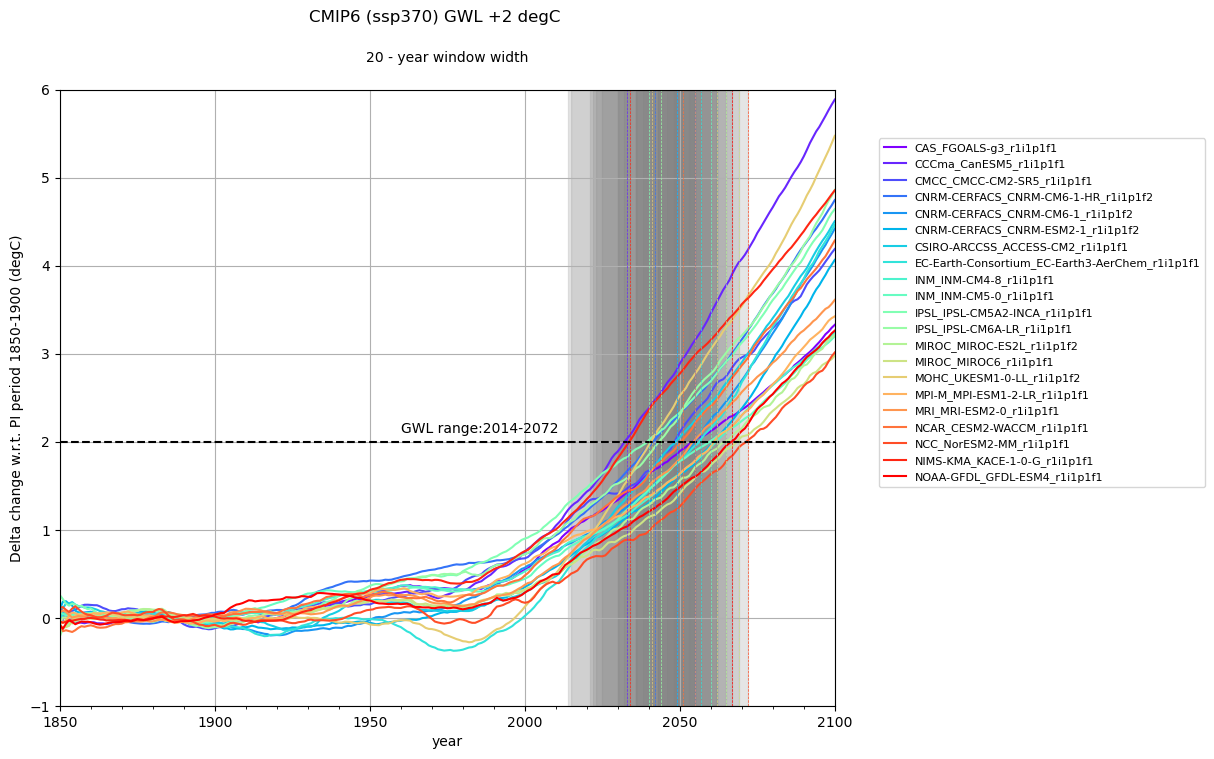

In [75]:
fig, ax = plt.subplots(figsize = (10, 8))
df_GWLs_serie_sce.plot(ax = ax, color = color)
ax.axhline(y = int(GWL), color='k', linestyle = '--')
for n, sim in enumerate(time_GWL_time.index):
    ax.axvline(x = time_GWL_time['year_right'].loc[sim], color = color[n], linestyle='--', 
               linewidth = 0.5, alpha = 1)
    ax.fill_between(x = [time_GWL_time['year_left'].loc[sim], time_GWL_time['year_right'].loc[sim]], 
                    y1 = -1, y2 = 6, color = 'grey', alpha = 0.2)
ax.legend(bbox_to_anchor = (1.05, 0.93), fontsize = 8)
ax.grid(True)
ax.set_ylabel("Delta change w.r.t. PI period 1850-1900 (degC)")
ax.set_xlabel("year")
ax.annotate('GWL range:' + str(np.min([int(period.split('-')[0]) for period in time_GWL.values])) 
                   + '-' + str(np.max([int(period.split('-')[1]) for period in time_GWL.values])), xy = (-10,int(GWL)+0.1))
ax.set_xticks(xticks)
ax.set_xticklabels([y.year for y in xticks])
ax.set_ylim([-1, 6])
plt.suptitle("CMIP6 (ssp370) GWL +2 degC")
plt.title("20 - year window width", fontsize = 10, pad = 20)

### IPCC Atlas validation

In [18]:
Copernicus_GWLs = {}
Atlas_GWLs = {}
for project in projects:
    # read GWLs results
    df_GWLs = pd.read_csv(project + '_WarmingLevels.csv', header=[0, 1], index_col=0)
    df_GWLs = df_GWLs.replace(9999, '9999')# Pandas presents a bug and convert the same value '9999' as '9999' and 9999.0
    df_GWLs_serie = pd.read_csv(project + '_WarmingSeries.csv', header=[0, 1], index_col=0, parse_dates=True)
    # read IPCC Atlas results
    root_Atlas = "https://raw.githubusercontent.com/IPCC-WG1/Atlas/main/warming-levels/" + project + "_Atlas_WarmingLevels.csv"
    CMIP_Atlas_WarmingLevels = pd.read_csv(root_Atlas, index_col = 0)
    
    C_G = []
    A_G = []
    for sim in df_GWLs.index:
        sim_Atlas_format = sim.split('_')[1] + '_' + sim.split('_')[2]
        if sim_Atlas_format in CMIP_Atlas_WarmingLevels.index:
            for GWL in GWLs:
                for sce in scenarios[project]: 
                    period = df_GWLs[(GWL, sce)].loc[sim]
                    if pd.notnull(period):
                        if not period == '9999':
                            Copernicus2IPCC_central_period = int(period.split('-')[1])-10
                            C_G.append(Copernicus2IPCC_central_period)
                            A_G.append(CMIP_Atlas_WarmingLevels[GWL + '_' + sce].loc[sim_Atlas_format]) 
    
    Copernicus_GWLs[project] = C_G
    Atlas_GWLs[project] = A_G

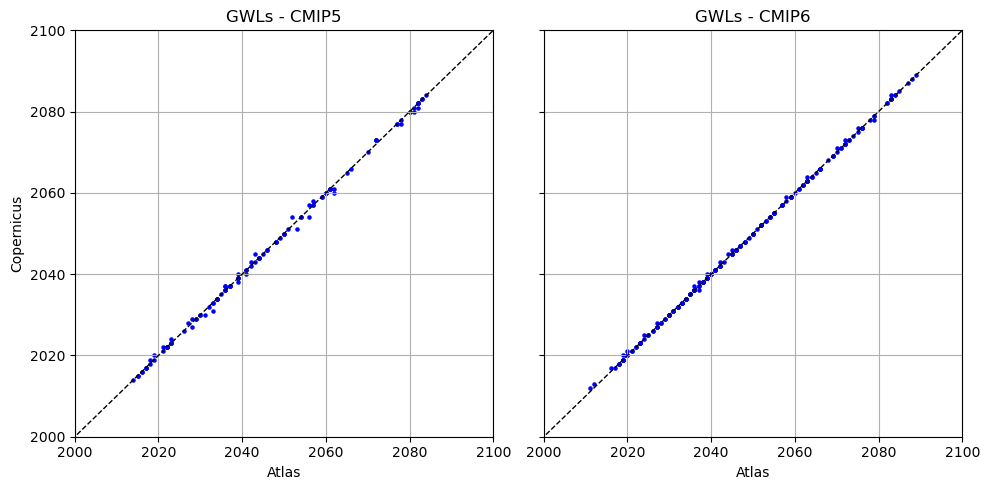

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (10,5), sharey = True, sharex = True)
for nc, project in enumerate(projects):
    ax[nc].plot([0,3000], [0, 3000], 'k--', linewidth=1)
    ax[nc].scatter(Atlas_GWLs[project], Copernicus_GWLs[project], s=5, c='b')
    ax[nc].set_xlim([2000, 2100])
    ax[nc].set_ylim([2000, 2100])
    ax[nc].grid(True)
    ax[nc].set_xlabel('Atlas')
    ax[nc].set_title('GWLs - ' + project)
ax[0].set_ylabel('Copernicus')
fig.tight_layout()
#plt.savefig('GWLs_AtlasvsCopernicus.pdf')

### Verifying the availability of all driving GCMs (CMIP5) for the CORDEX dataset in the CDS-C3S

In [43]:
def get_members_from_files(files):
    members = []
    for file in files:
        ds = xr.open_dataset(file)
        members.append(ds.member_id.values)
    return list(np.sort(np.unique(flatten_list(members))))

In [44]:
def flatten_list(nested_list):
    flat_list = []
    for sublist in nested_list:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [57]:
CORDEX_CORE_sim_v1 = {'AFR-22_MOHC_HadGEM2-ES_r1i1p1_GERICS-REMO2015_v1',
               'AUS-22_MOHC_HadGEM2-ES_r1i1p1_GERICS-REMO2015_v1',
               'CAM-22_MOHC_HadGEM2-ES_r1i1p1_GERICS-REMO2015_v1',
               'EAS-22_MOHC_HadGEM2-ES_r1i1p1_GERICS-REMO2015_v1',
               'EUR-11_MOHC_HadGEM2-ES_r1i1p1_GERICS-REMO2015_v1',
               'NAM-22_MOHC_HadGEM2-ES_r1i1p1_GERICS-REMO2015_v1', 
               'SAM-22_MOHC_HadGEM2-ES_r1i1p1_GERICS-REMO2015_v1',
               'SEA-22_MOHC_HadGEM2-ES_r1i1p1_GERICS-REMO2015_v1',
               'WAS-22_MOHC_HadGEM2-ES_r1i1p1_GERICS-REMO2015_v1', 
               
               'AFR-22_MOHC_HadGEM2-ES_r1i1p1_ICTP-RegCM4-7_v0',
               'AUS-22_MOHC_HadGEM2-ES_r1i1p1_ICTP-RegCM4-7_v0',
               'CAM-22_MOHC_HadGEM2-ES_r1i1p1_ICTP-RegCM4-7_v0',
               'EAS-22_MOHC_HadGEM2-ES_r1i1p1_ICTP-RegCM4-4_v0',
               'EUR-11_MOHC_HadGEM2-ES_r1i1p1_ICTP-RegCM4-6_v1',
               'NAM-22_MOHC_HadGEM2-ES_r1i1p1_ISU-RegCM4_v4-4-rc8', 
               'SAM-22_MOHC_HadGEM2-ES_r1i1p1_ICTP-RegCM4-7_v0',
               'SEA-22_MOHC_HadGEM2-ES_r1i1p1_ICTP-RegCM4-7_v0',
               'WAS-22_MIROC_MIROC5_r1i1p1_ORNL-RegCM4-7_v0', 
               
               'AFR-22_MPI-M_MPI-ESM-LR_r1i1p1_GERICS-REMO2015_v1',
               'AUS-22_MPI-M_MPI-ESM-LR_r1i1p1_GERICS-REMO2015_v1',
               'CAM-22_MPI-M_MPI-ESM-LR_r1i1p1_GERICS-REMO2015_v1',
               'EAS-22_MPI-M_MPI-ESM-LR_r1i1p1_GERICS-REMO2015_v1',
               'EUR-11_MPI-M_MPI-ESM-LR_r3i1p1_GERICS-REMO2015_v1',
               'NAM-22_MPI-M_MPI-ESM-LR_r1i1p1_GERICS-REMO2015_v1', 
               'SAM-22_MPI-M_MPI-ESM-LR_r1i1p1_GERICS-REMO2015_v1',
               'SEA-22_MPI-M_MPI-ESM-LR_r1i1p1_GERICS-REMO2015_v1',
               'WAS-22_MPI-M_MPI-ESM-LR_r1i1p1_GERICS-REMO2015_v1', 
               
               'AFR-22_MPI-M_MPI-ESM-MR_r1i1p1_ICTP-RegCM4-7_v0',
               'AUS-22_MPI-M_MPI-ESM-MR_r1i1p1_ICTP-RegCM4-7_v0',
               'CAM-22_MPI-M_MPI-ESM-MR_r1i1p1_ICTP-RegCM4-7_v0',
               'EAS-22_MPI-M_MPI-ESM-MR_r1i1p1_ICTP-RegCM4-4_v0',
               'EUR-11_MPI-M_MPI-ESM-LR_r1i1p1_ICTP-RegCM4-6_v1',
               'NAM-22_MPI-M_MPI-ESM-LR_r1i1p1_NCAR-RegCM4_v4-4-rc8', 
               'SAM-22_MPI-M_MPI-ESM-MR_r1i1p1_ICTP-RegCM4-7_v0',
               'SEA-22_MPI-M_MPI-ESM-MR_r1i1p1_ICTP-RegCM4-7_v0',
               'WAS-22_MPI-M_MPI-ESM-MR_r1i1p1_ORNL-RegCM4-7_v0', 
               
               'AFR-22_NCC_NorESM1-M_r1i1p1_GERICS-REMO2015_v1',
               'AUS-22_NCC_NorESM1-M_r1i1p1_GERICS-REMO2015_v1',
               'CAM-22_NCC_NorESM1-M_r1i1p1_GERICS-REMO2015_v1',
               'EAS-22_NCC_NorESM1-M_r1i1p1_GERICS-REMO2015_v1',
               'EUR-11_NCC_NorESM1-M_r1i1p1_GERICS-REMO2015_v1',
               'NAM-22_NCC_NorESM1-M_r1i1p1_GERICS-REMO2015_v1', 
               'SAM-22_NCC_NorESM1-M_r1i1p1_GERICS-REMO2015_v1',
               'SEA-22_NCC_NorESM1-M_r1i1p1_GERICS-REMO2015_v1',
               'WAS-22_NCC_NorESM1-M_r1i1p1_GERICS-REMO2015_v1', 
               
               'AFR-22_NCC_NorESM1-M_r1i1p1_ICTP-RegCM4-7_v0',
               'AUS-22_NCC_NorESM1-M_r1i1p1_ICTP-RegCM4-7_v0',
               'CAM-22_NOAA-GFDL_GFDL-ESM2M_r1i1p1_ICTP-RegCM4-7_v0',
               'EAS-22_NCC_NorESM1-M_r1i1p1_ICTP-RegCM4-4_v0',
               'EUR-11_NCC_NorESM1-M_r1i1p1_ICTP-RegCM4-6_v1',
               'NAM-22_NOAA-GFDL_GFDL-ESM2M_r1i1p1_ISU-RegCM4_v4-4-rc8',
               'SAM-22_NCC_NorESM1-M_r1i1p1_ICTP-RegCM4-7_v0',
               'SEA-22_NCC_NorESM1-M_r1i1p1_ICTP-RegCM4-7_v0',
               'WAS-22_NCC_NorESM1-M_r1i1p1_ORNL-RegCM4-7_v0'}

In [46]:
# CMIP5 members available in the CDS-C3S
root = "./data/CMIP5/historical/"
files_CMIP5 = glob.glob(root + "*.nc")
CMIP5_simulations = get_members_from_files(files_CMIP5)

In [58]:
# CORDEX (GCMs) members available in the CICA-Atlas v1
root = "./CORDEX-EUR-11/historical/"
files_CORDEX_EUR_11 = glob.glob(root + '/*.nc')
CORDEX_EUR_11_simulations = get_members_from_files(files_CORDEX_EUR_11)
CORDEX_CORE_simulations = ['_'.join(m.split('_')[1:]) for m in CORDEX_CORE_sim_v1]
CORDEX_CICA_Atlas_v1_simulations = CORDEX_EUR_11_simulations + CORDEX_CORE_simulations
CORDEX_CICA_Atlas_v1_GCM_simulations =\
                        np.unique(['_'.join(m.split('_')[0:3]) for m in CORDEX_CICA_Atlas_v1_simulations])

In [63]:
# CMIP5 models inclued in the CORDEX v1 dataset
np.intersect1d(CORDEX_CICA_Atlas_v1_GCM_simulations, CMIP5_simulations)

array(['CCCma_CanESM2_r1i1p1', 'CNRM-CERFACS_CNRM-CM5_r1i1p1',
       'ICHEC_EC-EARTH_r12i1p1', 'IPSL_IPSL-CM5A-MR_r1i1p1',
       'MOHC_HadGEM2-ES_r1i1p1', 'MPI-M_MPI-ESM-LR_r1i1p1',
       'MPI-M_MPI-ESM-LR_r2i1p1', 'MPI-M_MPI-ESM-LR_r3i1p1',
       'MPI-M_MPI-ESM-MR_r1i1p1', 'NCC_NorESM1-M_r1i1p1'], dtype='<U33')

In [64]:
# CMIP5 models not included in the CORDEX v1 dataset (NOAA-GFDL is included but it is wrong spelled in the CMIP5 datset)
np.setdiff1d(CORDEX_CICA_Atlas_v1_GCM_simulations, CMIP5_simulations)

array(['ICHEC_EC-EARTH_r1i1p1', 'ICHEC_EC-EARTH_r3i1p1',
       'MIROC_MIROC5_r1i1p1', 'NOAA-GFDL_GFDL-ESM2M_r1i1p1'], dtype='<U28')

In [79]:
# CORDEX (GCMs) members available in the IPCC-Atlas (excluding EUR)
root = '.data/ipcc-ar6-interactive-atlas-dataset/'
domains = ['AFR', 'ANT', 'ARC', 'AUS', 'CAM', 'EAS', 'NAM', 'SAM', 'SEA', 'WAS']
CORDEX_IPCC_Atlas_files = []
for dom in domains:
    CORDEX_IPCC_Atlas_files.append(glob.glob(root + 'CORDEX-' +  dom + '/historical/*.nc'))
CORDEX_IPCC_Atlas_files = flatten_list(CORDEX_IPCC_Atlas_files)
CORDEX_IPCC_Atlas_simulations = get_members_from_files(CORDEX_IPCC_Atlas_files)
CORDEX_IPCC_Atlas_GCM_simulations=\
                        np.unique(['_'.join(m.split('_')[0:3]) for m in CORDEX_IPCC_Atlas_simulations])

In [82]:
# CMIP5 models inclued in the CORDEX IPCC-Atlas dataset (excluding EUR)
np.intersect1d(CORDEX_IPCC_Atlas_GCM_simulations, CMIP5_simulations)

array(['CCCma_CanESM2_r1i1p1', 'CNRM-CERFACS_CNRM-CM5_r1i1p1',
       'CSIRO-BOM_ACCESS1-0_r1i1p1', 'CSIRO-BOM_ACCESS1-3_r1i1p1',
       'CSIRO-QCCCE_CSIRO-Mk3-6-0_r1i1p1', 'ICHEC_EC-EARTH_r12i1p1',
       'IPSL_IPSL-CM5A-MR_r1i1p1', 'MOHC_HadGEM2-ES_r1i1p1',
       'MPI-M_MPI-ESM-LR_r1i1p1', 'MPI-M_MPI-ESM-MR_r1i1p1',
       'NCC_NorESM1-M_r1i1p1'], dtype='<U33')

In [83]:
# CMIP5 models not inclued in the CORDEX IPCC-Atlas dataset (excluding EUR)
np.setdiff1d(CORDEX_IPCC_Atlas_GCM_simulations, CMIP5_simulations)

array(['ICHEC_EC-EARTH_r1i1p1', 'ICHEC_EC-EARTH_r3i1p1',
       'IPSL_IPSL-CM5A-LR_r1i1p1', 'MIROC_MIROC5_r1i1p1',
       'NOAA-GFDL_GFDL-ESM2G_r1i1p1', 'NOAA-GFDL_GFDL-ESM2M_r1i1p1'],
      dtype='<U32')

# Complete the GWLs calculated with the CMIP5 datasets available on the C3S-CDS using the IPCC-Atlas

In [84]:
root_IPCC_Atlas = "https://raw.githubusercontent.com/IPCC-WG1/Atlas/main/warming-levels/CMIP5_Atlas_WarmingLevels.csv"
CMIP5_IPCC_Atlas_GWLs = pd.read_csv(root_IPCC_Atlas, index_col = 0)

In [96]:
CMIP5_CICA_Atlas_GWLs = pd.read_csv("CMIP5_WarmingLevels.csv", header=[0, 1], index_col = [0])

In [102]:
IPCC_Atlas_GWLs = {
    "ICHEC_EC-EARTH_r1i1p1" : ['9999', '9999', '9999', '9999', '9999', '9999', '9999', '9999', '9999', '9999', '9999', '9999'],
    "ICHEC_EC-EARTH_r3i1p1" : ['9999', '9999', '9999', '9999', 2022, 2044, 'NA', 'NA', 2020, 2038, 2061, 2081],
    "MIROC_MIROC5_r1i1p1" :   [2046, 'NA', 'NA', 'NA', 2039, 2071, 'NA', 'NA', 2033, 2048, 2072, 'NA']
}

# set period from central year [YYYY-9, YYYY+10]

for sim in IPCC_Atlas_GWLs:
    for n_val, val in enumerate(IPCC_Atlas_GWLs[sim]):
        if val != 'NA' and val != '9999':
            IPCC_Atlas_GWLs[sim][n_val] = str(val-9) + '-' + str(val+10)

In [103]:
for sim in IPCC_Atlas_GWLs:
    CMIP5_CICA_Atlas_GWLs.loc[sim] = IPCC_Atlas_GWLs[sim]

In [109]:
# fix NOAA GFDL_GFDL
index_ = [sim.replace(' ', '-') for sim in CMIP5_CICA_Atlas_GWLs.index]
CMIP5_CICA_Atlas_GWLs.index = index_

In [113]:
CMIP5_CICA_Atlas_GWLs.to_csv('CMIP5_WarmingLevels_plusIPCC-Atlas.csv')

# GWLs for CORDEX-CORE
The names of the simulations in the CORDEX-CORE v1 dataset were simplified to reduce the number of members by not including the ensemble member and the version of the model. Thus, to facilitate the interaction between the CICA visor and the GWLs, we decided to create the following auxiliary file.

In [14]:
CMIP5_CICA_Atlas_GWLs = pd.read_csv('CMIP5_WarmingLevels_plusIPCC-Atlas.csv', header=[0, 1], index_col = [0])

In [2]:
def associate_core(self):
    Dict={}

    for model in self.list_core()["list_core_refact"]:
        Dict[model]={}
    Dict["MOHC_HadGEM2-ES_REMO"]["models"]=["MOHC_HadGEM2-ES_r1i1p1_GERICS_REMO2015_v1"]
    Dict["MOHC_HadGEM2-ES_RegCM"]["models"]=["MOHC_HadGEM2-ES_r1i1p1_ICTP_RegCM4-7_v0" , "MOHC_HadGEM2-ES_r1i1p1_ICTP_RegCM4-4_v0" , "MOHC_HadGEM2-ES_r1i1p1_ICTP_RegCM4-6_v1","MOHC_HadGEM2-ES_r1i1p1_ISU_RegCM4_v4-4-rc8"]       
    Dict["MPI-M_MPI-ESM-LR_REMO"]["models"]=["MPI-M_MPI-ESM-LR_r1i1p1_GERICS_REMO2015_v1","MPI-M_MPI-ESM-LR_r3i1p1_GERICS_REMO2015_v1"]
    Dict["MPI-M_MPI-ESM-MR_RegCM"]["models"]=["MPI-M_MPI-ESM-MR_r1i1p1_ICTP_RegCM4-7_v0","MPI-M_MPI-ESM-MR_r1i1p1_ICTP_RegCM4-4_v0","MPI-M_MPI-ESM-MR_r1i1p1_ORNL_RegCM4-7_v0"]
    Dict["NCC_NorESM1-M_REMO"]["models"]=["NCC_NorESM1-M_r1i1p1_GERICS_REMO2015_v1"]
    Dict["NCC_NorESM1-M_RegCM"]["models"]=["NCC_NorESM1-M_r1i1p1_ICTP_RegCM4-7_v0","NCC_NorESM1-M_r1i1p1_ICTP_RegCM4-4_v0","NCC_NorESM1-M_r1i1p1_ICTP_RegCM4-6_v1","NCC_NorESM1-M_r1i1p1_ORNL_RegCM4-7_v0"]
    Dict["NOAA-GFDL_GFDL-ESM2M_RegCM"]["models"]=["NOAA-GFDL_GFDL-ESM2M_r1i1p1_ICTP_RegCM4-7_v0","NOAA-GFDL_GFDL-ESM2M_r1i1p1_ISU_RegCM4_v4-4-rc8"]
    Dict["MIROC_MIROC5_RegCM"]["models"]=["MIROC_MIROC5_r1i1p1_ORNL-RegCM4-7_v0"]
    Dict["MPI-M_MPI-ESM-LR_RegCM"]["models"]=["MPI-M_MPI-ESM-LR_r1i1p1_ICTP_RegCM4-6_v0","MPI-M_MPI-ESM-LR_r1i1p1_NCAR_RegCM4_v4-4-rc8","MPI-M_MPI-ESM-LR_r1i1p1_ICTP_RegCM4-6_v1"]

    Dict["MOHC_HadGEM2-ES_REMO"]["domains"]=["AFR","AUS","CAM","EAS","EUR","NAM","SAM","SEA","WAS"]
    Dict["MOHC_HadGEM2-ES_RegCM"]["domains"]=["AFR","AUS","CAM","EAS","EUR","NAM","SAM","SEA"]
    Dict["MPI-M_MPI-ESM-LR_REMO"]["domains"]=["AFR","AUS","CAM","EAS","EUR","NAM","SAM","SEA","WAS"]
    Dict["MPI-M_MPI-ESM-MR_RegCM"]["domains"]=["AFR","AUS","CAM","EAS","SAM","SEA","WAS"]
    Dict["NCC_NorESM1-M_REMO"]["domains"]=["AFR","AUS","CAM","EAS","EUR","NAM","SAM","SEA","WAS"]
    Dict["NCC_NorESM1-M_RegCM"]["domains"]=["AFR","AUS","EAS","EUR","SAM","SEA","WAS"]
    Dict["NOAA-GFDL_GFDL-ESM2M_RegCM"]["domains"]=["CAM","NAM","SEA"]
    Dict["MIROC_MIROC5_RegCM"]["domains"]=["EUR","WAS"]
    Dict["MPI-M_MPI-ESM-LR_RegCM"]["domains"]=["EUR","NAM"]

    return Dict

In [ ]:
np.array([[1, 2], [3, 4]])

In [11]:
CORE_GCMs = np.array([['MOHC_HadGEM2-ES_REMO', 'MOHC_HadGEM2-ES_r1i1p1'],
         ['MOHC_HadGEM2-ES_RegCM', 'MOHC_HadGEM2-ES_r1i1p1'],
         ['MPI-M_MPI-ESM-LR_REMO', 'MPI-M_MPI-ESM-LR_r1i1p1'],
         ['MPI-M_MPI-ESM-MR_RegCM', 'MPI-M_MPI-ESM-MR_r1i1p1'],
         ['NCC_NorESM1-M_REMO', 'NCC_NorESM1-M_r1i1p1'],
         ['NCC_NorESM1-M_RegCM', 'NCC_NorESM1-M_r1i1p1'],
         ['NOAA-GFDL_GFDL-ESM2M_RegCM', 'NOAA-GFDL_GFDL-ESM2M_r1i1p1'],
         ['MIROC_MIROC5_RegCM', 'MIROC_MIROC5_r1i1p1'],
         ['MPI-M_MPI-ESM-LR_RegCM', 'MPI-M_MPI-ESM-LR_r1i1p1']])

In [12]:
CORE_GCMs_df = pd.DataFrame(CORE_GCMs, columns=['CORDEX-CORE', 'GCMs'])

In [13]:
CORE_GCMs_df

,CORDEX-CORE,GCMs
0,MOHC_HadGEM2-ES_REMO,MOHC_HadGEM2-ES_r1i1p1
1,MOHC_HadGEM2-ES_RegCM,MOHC_HadGEM2-ES_r1i1p1
2,MPI-M_MPI-ESM-LR_REMO,MPI-M_MPI-ESM-LR_r1i1p1
3,MPI-M_MPI-ESM-MR_RegCM,MPI-M_MPI-ESM-MR_r1i1p1
4,NCC_NorESM1-M_REMO,NCC_NorESM1-M_r1i1p1
5,NCC_NorESM1-M_RegCM,NCC_NorESM1-M_r1i1p1
6,NOAA-GFDL_GFDL-ESM2M_RegCM,NOAA-GFDL_GFDL-ESM2M_r1i1p1
7,MIROC_MIROC5_RegCM,MIROC_MIROC5_r1i1p1
8,MPI-M_MPI-ESM-LR_RegCM,MPI-M_MPI-ESM-LR_r1i1p1


In [30]:
CORDEX_CORE_GWLs = CMIP5_CICA_Atlas_GWLs.loc[CORE_GCMs_df['GCMs']]

In [31]:
CORDEX_CORE_GWLs = CORDEX_CORE_GWLs.set_index(CORE_GCMs_df['CORDEX-CORE'].values)

In [32]:
CORDEX_CORE_GWLs

,1.5,2,3,4,1.5,2,3,4,1.5,2,3,4
,rcp26,rcp26,rcp26,rcp26,rcp45,rcp45,rcp45,rcp45,rcp85,rcp85,rcp85,rcp85
MOHC_HadGEM2-ES_REMO,2015-2034,NaN,NaN,NaN,2020-2039,2036-2055,NaN,NaN,9999,9999,9999,9999
MOHC_HadGEM2-ES_RegCM,2015-2034,NaN,NaN,NaN,2020-2039,2036-2055,NaN,NaN,9999,9999,9999,9999
MPI-M_MPI-ESM-LR_REMO,2013-2032,NaN,NaN,NaN,2013-2032,2035-2054,NaN,NaN,2008-2027,2028-2047,2052-2071,2072-2091
MPI-M_MPI-ESM-MR_RegCM,2014-2033,NaN,NaN,NaN,2014-2033,2036-2055,NaN,NaN,2011-2030,2030-2049,2051-2070,2073-2092
NCC_NorESM1-M_REMO,NaN,NaN,NaN,NaN,2030-2049,2064-2083,NaN,NaN,2023-2042,2039-2058,2064-2083,NaN
NCC_NorESM1-M_RegCM,NaN,NaN,NaN,NaN,2030-2049,2064-2083,NaN,NaN,2023-2042,2039-2058,2064-2083,NaN
NOAA-GFDL_GFDL-ESM2M_RegCM,NaN,NaN,NaN,NaN,2037-2056,NaN,NaN,NaN,2027-2046,2042-2061,2073-2092,NaN
MIROC_MIROC5_RegCM,2037-2056,NaN,NaN,NaN,2030-2049,2062-2081,NaN,NaN,2024-2043,2039-2058,2063-2082,NaN
MPI-M_MPI-ESM-LR_RegCM,2013-2032,NaN,NaN,NaN,2013-2032,2035-2054,NaN,NaN,2008-2027,2028-2047,2052-2071,2072-2091


In [33]:
CORDEX_CORE_GWLs.to_csv('CORDEX-CORE_WarmingLevels_plusIPCC-Atlas.csv')